# Part 0: Choose pretrained image classification model and images to be explained

## Imports

We chose to use VGG16. We will download it pretrained and establish its performance on 100 images

In [36]:
import torch
import torchvision.models as models
from torchvision import transforms
import os
from pathlib import Path
import requests
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import urllib.request
import requests
from bs4 import BeautifulSoup
import time

## Part 0: get the model

In [34]:
model = models.vgg16(pretrained=True)
model.eval()
pass

/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
image_dir = "images"

### Download images, imagenet classes

In [39]:
def download_unsplash_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        image_element = soup.find("meta", property="og:image")
        if image_element:
            image_url = image_element["content"]
            image_response = requests.get(image_url)
            if image_response.status_code == 200:
                timestamp = int(time.time())
                filename = f"images/image_{timestamp}.jpg"
                with open(filename, "wb") as f:
                    f.write(image_response.content)
                print(f"Image downloaded successfully as '{filename}'!")
            else:
                print("Failed to download the image.")
        else:
            print("Image URL not found on the page.")
    else:
        print("Failed to retrieve the page.")


Path(image_dir).mkdir(exist_ok=True, parents=True)
# Download a turtle image
turtle_image_url = 'https://unsplash.com/photos/L-2p8fapOA8'
download_unsplash_image(turtle_image_url)

# Download a cat image
dog_image_url = 'https://unsplash.com/photos/5GcNMK0iQPk'
download_unsplash_image(dog_image_url)

# Download a basketball image
basketball_image_url = 'https://unsplash.com/photos/Gl0jBJJTDWs'
download_unsplash_image(basketball_image_url)


# Define the URL to download the ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Define the filename to save the class labels
filename = "imagenet_classes.txt"

# Download the class labels
urllib.request.urlretrieve(url, filename)

print("ImageNet class labels downloaded successfully!")

with open("imagenet_classes.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

Image downloaded successfully as 'images/image_1686661882.jpg'!
Image downloaded successfully as 'images/image_1686661882.jpg'!
Image downloaded successfully as 'images/image_1686661884.jpg'!
ImageNet class labels downloaded successfully!


## Part 1: Choose pretrained image classification model

In [54]:
# visualize the images in the folder 'images', and put in the title the vgg prediction of the image

# Define the transformation for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


def read_image_and_inferece_and_plot(image_path, plot=False):
    orig_im = Image.open(image_path)
    im = transform(orig_im)
    im = im.unsqueeze(0)
    with torch.no_grad():
        outputs = model(im)
    _, predicted_indices = torch.topk(outputs, k=3)
    predicted_indices = predicted_indices.squeeze().tolist()
    print("Top predicted classes:")
    for index in predicted_indices:
        print(f"{class_names[index]}")

    if plot:
        fig = plt.figure(figsize=(8, 12))
        plt.imshow(orig_im)
        plt.title(f"{class_names[predicted_indices[0]]}")
        plt.show()

    top_1_class_name = class_names[predicted_indices[0]]
    
    return orig_im, predicted_indices[:3], top_1_class_name
    


#### Vosualize image and their predictions

Top predicted classes:
"Dobermann",
"Black and Tan Coonhound",
"Rottweiler",


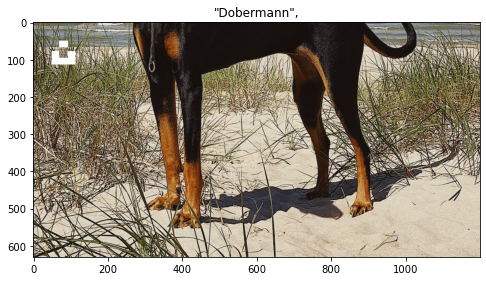

Top predicted classes:
"loggerhead sea turtle",
"leatherback sea turtle",
"terrapin",


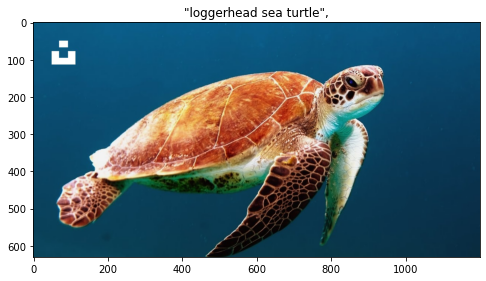

Top predicted classes:
"basketball",
"rugby ball",
"punching bag",


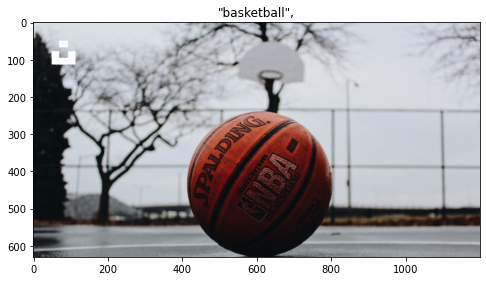

In [42]:

for image_path in Path(image_dir).iterdir():
    read_image_and_inferece_and_plot(image_path, plot=True)


There are 218 super pixels types
There are 218 average colors


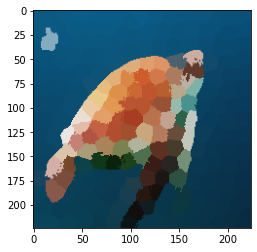

In [43]:
def get_super_pixels(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    slic = cv2.ximgproc.createSuperpixelSLIC(image_lab, region_size=15)
    slic.iterate(10)  # Number of iterations for refinement
    labels = slic.getLabels()
    mask = slic.getLabelContourMask()
    result = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    result = cv2.addWeighted(image, 0.5, result, 0.5, 0)
    return result, labels
    
# example:
image_path = Path("images/image_1686658265.jpg")
image = np.array(Image.open(image_path).resize((224, 224)))
result, labels = get_super_pixels(image)
print(f"There are {len(np.unique(labels))} super pixels types")

# using the labels, create a new image where each super pixel is colored with the average color of the super pixel

def get_average_color(image, labels):
    unique_labels = np.unique(labels)
    average_colors = []
    for label in unique_labels:
        indices = np.where(labels == label)
        average_color = np.mean(image[indices], axis=0)
        average_colors.append(average_color)
    return average_colors

average_colors = get_average_color(image, labels)
print(f"There are {len(average_colors)} average colors")

# plot the image with the average colors

def plot_image_with_average_colors(image, labels, average_colors):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        image[indices] = average_colors[label]
    plt.imshow(image)
    plt.show()

plot_image_with_average_colors(image, labels, average_colors)

## Main loop

Top predicted classes:
"Dobermann",
"Black and Tan Coonhound",
"Rottweiler",


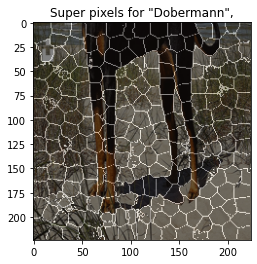

In [55]:

for image_path in Path(image_dir).iterdir():
  orig_img, top_3_classes, top_1_class_name = read_image_and_inferece_and_plot(image_path, plot=False)

  # 4a
  # resize the image to 224x224
  orig_img = orig_img.resize((224, 224))
  super_pixels, labels = get_super_pixels(np.array(orig_img))
  plt.imshow(super_pixels)
  plt.title(f"Super pixels for {top_1_class_name}")
  plt.show()

  # 4b
  # Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels 𝑥$ ∈ {0,1}%!
  # one hot encode the labels
  num_of_super_pixels = len(np.unique(labels))
  one_hot_labels = np.zeros((labels.shape[0], labels.shape[1], num_of_super_pixels))
  for i in range(num_of_super_pixels):
      one_hot_labels[:, :, i] = (labels == i).astype(int)

  # 5a
  # i
  
  break  
  


In [12]:
image_path = "/mnt/raid/home/eyal_michaeli/git/IDC_masters/semester_4/advanced_ml/images/image_1686658253.jpg"

Image.open(image_path).size

(1200, 630)

In [4]:
  image_path = "/mnt/raid/home/eyal_michaeli/git/IDC_masters/semester_4/advanced_ml/images/image_1686658253.jpg"
  image = np.array(Image.open(str(image_path)).resize((224, 224)))
  image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
  slic = cv2.ximgproc.createSuperpixelSLIC(image_lab, region_size=10)
  slic.iterate(10)  # Number of iterations for refinement
  labels = slic.getLabels()
  mask = slic.getLabelContourMask()
  result = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
  result = cv2.addWeighted(image, 0.5, result, 0.5, 0)
  cv2.imshow("Superpixels", result)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

: 

: 